# Import Statements

In [1]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# Initializing Scraped & Pre-Cleaned Dataframe

In [2]:
path = 'C:\\Users\\missn\\Documents\\Thinkful\\Python Notebooks\\2 Bootcamp\\Output_Clean.csv'
output_clean = pd.read_csv(path, index_col = 0)

In [3]:
output_clean.head()

,Search Term,Site,Link,Document
0,Ambazonia,Vanguard,https://www.vanguardngr.com/2018/02/vision-amb...,By Emmanuel Unah & Victoria Ojeme This Insigh...
2,Ambazonia,Vanguard,https://www.vanguardngr.com/2018/02/declared-a...,"By Emmanuel Unah, Victoria Ojeme & Dotun Ibiw..."
4,Ambazonia,Vanguard,https://www.vanguardngr.com/2018/04/france-amb...,"By Derric Yuh For the past three weeks, an en..."
6,Ambazonia,Vanguard,https://www.vanguardngr.com/tag/ambazonia/,"In Manyu in particular, schools cannot re-ope..."
8,Ambazonia,Vanguard,https://www.vanguardngr.com/tag/ambazonia-repu...,"In the English speaking part of Cameroun, if..."


# Deep String Cleaning: HTML & JavaScript Residue

In [4]:
output_clean['Site'].value_counts()

Independent      79
The Nation       20
Cameroon Post    20
Daily Trust      20
Sun News         20
Vanguard         20
Tribune          15
Bareta News      14
Name: Site, dtype: int64

## Vanguard (0-19)

In [5]:
output_clean['Document'] = output_clean['Document'].str.replace(r'\r.+\r',' ')
output_clean['Document'] = output_clean['Document'].str.replace(u'\xa0',' ')
output_clean['Document'] = output_clean['Document'].str.replace(r'Related +$','')

## Sun News (20-39)

In [6]:
output_clean['Document'] = output_clean['Document'].str.replace(r'\(adsbygoogle = window\.adsbygoogle \|\| \[\]\)\.push\(\{\}\);','')
output_clean['Document'] = output_clean['Document'].str.replace(r'function insertAfter.+$','')
output_clean['Document'] = output_clean['Document'].str.replace(r'READ ALSO: .+$','')

## The Nation (40-59)

In [7]:
output_clean['Document'] = output_clean['Document'].str.replace(r'Do you get a good or bad response from your wife after making love.+$','')

## Tribune (60-74)

In [8]:
output_clean['Document'] = output_clean['Document'].str.replace(r'Courtesy:.+$','')
output_clean['Document'] = output_clean['Document'].str.replace(r'Share this:.+$','')

## Daily Trust (75-94)

In [9]:
output_clean['Document'] = output_clean['Document'].str.replace(u'\\u200e','')
output_clean['Document'] = output_clean['Document'].str.replace(r'\/ AFP PHOTO','')
output_clean['Document'] = output_clean['Document'].str.replace(r'#notatarget.+$','')

## Independent (95-173)

In [10]:
output_clean['Document'] = output_clean['Document'].str.replace(r'window\._taboola.+$','')

## Bareta News (174-187)

**There was no need to clean these articles using regular expressions.** 

## Cameroon Post (188-207)

In [11]:
output_clean['Document'] = output_clean['Document'].str.replace(r'Posted in:.+$','')

## Dropping Irrelevant/Truncated Documents & Intra-Source Duplicates

In [12]:
output_clean = output_clean.drop([6, 8, 49, 50, 57, 64, 66, 78, 115, 133, 135, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 198, 200, 204, 205, 206, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 246, 247, 248, 251, 252, 253, 270, 272, 274, 276, 280, 282, 284, 288, 292, 294, 296, 298, 300, 304, 306])

## Lowercasing, String Cleaning, & Dropping Inter-Source Duplicates

In [13]:
output_clean['Document'] = output_clean['Document'].str.lower()

In [14]:
output_clean['Document'] = output_clean['Document'].str.replace(r'[^a-zA-z\s]',' ')

In [15]:
output_clean['Document'].duplicated().value_counts()

False    102
True      20
Name: Document, dtype: int64

In [16]:
output_clean = output_clean.drop_duplicates(subset = ['Document'],keep = 'first')

In [17]:
output_clean['Search Term'].value_counts()

Boko Haram    57
Ambazonia     45
Name: Search Term, dtype: int64

# Modeling

## Setup

In [18]:
X_train, X_test = train_test_split(output_clean, test_size = 0.25, stratify = output_clean['Search Term'], random_state = 0)

In [19]:
additional_stop_words = ['ambazonia', 'ambazonian', 'boko', 'haram', 'cameroon', 'cameroons', 'cameroun', 'camerouns', 'dr', 'cameroonian', 'nigeria', 'nigerian', 'posted', 'reintegrated', 'said', 'say']
stop_words = esw.union(additional_stop_words)
initial_vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, ngram_range = (1, 2)) 

In [20]:
X_train['Search Term'].value_counts()

Boko Haram    42
Ambazonia     34
Name: Search Term, dtype: int64

In [21]:
X_test['Search Term'].value_counts()

Boko Haram    15
Ambazonia     11
Name: Search Term, dtype: int64

## Parameter Tuning: Latent Dirichlet Allocation Model

In [22]:
min_df = [0.01, 0.015, 0.02, 0.025]
max_df = [0.75, 0.55, 0.5, 0.45]
n_topics = [2, 4, 6, 8, 10]
parameters = dict(Vectorizer__min_df = min_df, Vectorizer__max_df = max_df, LDAStep__n_topics = n_topics)

In [23]:
lda_step = LatentDirichletAllocation(random_state = 0)
lda_pipeline = Pipeline(steps = [('Vectorizer', initial_vectorizer), ('LDAStep', lda_step)])

lda_pipeline_gridsearch = GridSearchCV(lda_pipeline, parameters, n_jobs = 2)
lda_pipeline_gridsearch.fit(X_train['Document'])
best_lda_model = lda_pipeline_gridsearch.best_estimator_

print("Best Parameters: ", lda_pipeline_gridsearch.best_params_)

Best Parameters:  {'LDAStep__n_topics': 2, 'Vectorizer__max_df': 0.45, 'Vectorizer__min_df': 0.025}


## Post-Parameter Tuning Revisions

In [24]:
final_vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, ngram_range = (1, 2), max_df = 0.45, min_df = 0.025) 

In [25]:
X_train_tfidf = final_vectorizer.fit_transform(X_train['Document'])
X_test_tfidf = final_vectorizer.transform(X_test['Document'])

In [26]:
terms = final_vectorizer.get_feature_names()
ntopics = 2
n_top_words = 5

def word_topic(tfidf, solution, wordlist):
    words_by_topic = tfidf.T * solution
    components = pd.DataFrame(words_by_topic, index = wordlist)  
    return components

def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index = np.repeat(n_topics, n_top_words, axis = 0)
    topwords = pd.Series(index = index)
    
    for column in range(components.shape[1]):
        sortedwords = components.iloc[:,column].sort_values(ascending = False)
        chosen = sortedwords[:n_top_words]
        chosenlist = chosen.index + " " + round(chosen, 2).map(str) 
        topwords.loc[column] = chosenlist
    return(topwords)

topwords = pd.DataFrame()

## Model 1A: Latent Dirichlet Allocation

In [27]:
lda = LatentDirichletAllocation(ntopics, random_state = 0)
X_train_lda = lda.fit_transform(X_train_tfidf)
X_test_lda = lda.transform(X_test_tfidf)

In [28]:
components_lda_train = word_topic(X_train_tfidf, X_train_lda, terms)
topwords['LDA Training Set'] = top_words(components_lda_train, n_top_words)

components_lda_test = word_topic(X_test_tfidf, X_test_lda, terms)
topwords['LDA Test Set'] = top_words(components_lda_test, n_top_words)

In [29]:
lda_scaler = preprocessing.QuantileTransformer()
X_train_lda = lda_scaler.fit_transform(X_train_lda)
X_test_lda = lda_scaler.transform(X_test_lda)

### LDA Dataframe Creation: Training Set

In [30]:
train_lda = pd.DataFrame()
train_lda = X_train
lda_df_train = pd.DataFrame(X_train_lda, index = train_lda.index)
train_lda = pd.concat([train_lda, lda_df_train], axis = 1)
train_lda['Topic'] = train_lda.iloc[:, 4:6].idxmax(axis = 1)
train_lda.head()

,Search Term,Site,Link,Document,0,1,Topic
89,Boko Haram,The Nation,http://thenationonlineng.net/boko-haram-sacks-...,suspected boko haram insurgents on saturday...,0.253279,0.746721,1
72,Ambazonia,The Nation,http://thenationonlineng.net/southern-cameroon...,agitation for independence sparks alleged...,0.800012,0.199988,0
31,Boko Haram,Vanguard,https://www.vanguardngr.com/2018/10/breaking-b...,boko haram jihadists on saturday hacked fa...,0.147100,0.852900,1
51,Ambazonia,Sun News,http://sunnewsonline.com/biafra-pro-biafra-gro...,jeff amechi agbodo onitsha the coa...,0.626864,0.373136,0
240,Boko Haram,Independent,https://www.independent.ng/fg-reintegrates-254...,bamidele shafa the federal government has sai...,0.093511,0.906489,1


### LDA Topic Distribution: Training Set

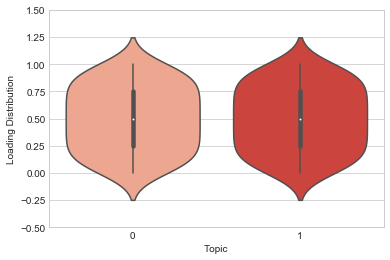

In [31]:
loadings_lda_violin_train = sns.violinplot(data = train_lda.iloc[:, 4:6], palette = 'Reds')
x_label = plt.xlabel("Topic") 
y_label = plt.ylabel("Loading Distribution") 
y_lim = plt.ylim(-0.5, 1.5)

### LDA Document Distribution Into Topics: Training Set

In [32]:
train_lda['Topic'].value_counts()

1    38
0    38
Name: Topic, dtype: int64

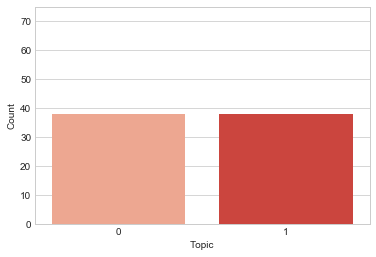

In [33]:
lda_topic_dist_train = sns.countplot(x = train_lda['Topic'], palette = 'Reds')
y_label = plt.ylabel("Count") 
y_lim = plt.ylim(0, 75)

### LDA Training Set Confusion Matrix: 'Topic' vs. 'Search Term'

In [34]:
train_lda['Recode'] = np.where(train_lda['Search Term'] == 'Ambazonia', 0, 1)

In [35]:
actuals_train_lda = train_lda['Recode']
predictions_train_lda = train_lda['Topic']
matrix_train_lda = confusion_matrix(actuals_train_lda, predictions_train_lda)
tI_errors_train_lda = (matrix_train_lda[0][1] / (matrix_train_lda[0][0] + matrix_train_lda[0][1]))
tII_errors_train_lda = (matrix_train_lda[1][0] / (matrix_train_lda[1][0] + matrix_train_lda[1][1]))
print(('LDA Training Set Type I Error Rate: {:.2%}.\n'
       'LDA Training Set Type II Error Rate: {:.2%}.\n').format(tI_errors_train_lda, tII_errors_train_lda))

LDA Training Set Type I Error Rate: 14.71%.
LDA Training Set Type II Error Rate: 21.43%.



### LDA Dataframe Creation: Test Set

In [36]:
test_lda = pd.DataFrame()
test_lda = X_test
lda_df_test = pd.DataFrame(X_test_lda, index = test_lda.index)
test_lda = pd.concat([test_lda, lda_df_test], axis = 1)
test_lda['Topic'] = test_lda.iloc[:, 4:6].idxmax(axis = 1)
test_lda.head()

,Search Term,Site,Link,Document,0,1,Topic
236,Boko Haram,Independent,https://www.independent.ng/boko-haram-kills-12...,the national emergency management agency ne...,0.273230,0.726770,1
80,Ambazonia,The Nation,http://thenationonlineng.net/grand-deception-1...,nigerians especially those living in urban c...,0.733107,0.266893,0
47,Ambazonia,Sun News,http://sunnewsonline.com/gov-ayade-raises-alar...,nan gov ben ayade of cross river h...,0.674618,0.325382,0
238,Boko Haram,Independent,https://www.independent.ng/boko-haram-sacks-tw...,suspected boko haram insurgents on saturday ...,0.256795,0.743205,1
124,Boko Haram,Tribune,https://www.tribuneonlineng.com/165727/,the igbo professionals in diasp...,0.559952,0.440048,0


### LDA Topic Distribution: Test Set

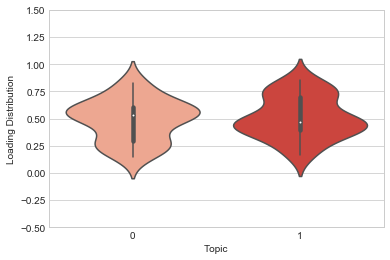

In [37]:
loadings_lda_violin_test = sns.violinplot(data = test_lda.iloc[:, 4:6], palette = 'Reds')
x_label = plt.xlabel("Topic") 
y_label = plt.ylabel("Loading Distribution") 
y_lim = plt.ylim(-0.5, 1.5)

### LDA Document Distribution Into Topics: Test Set

In [38]:
test_lda['Topic'].value_counts()

0    15
1    11
Name: Topic, dtype: int64

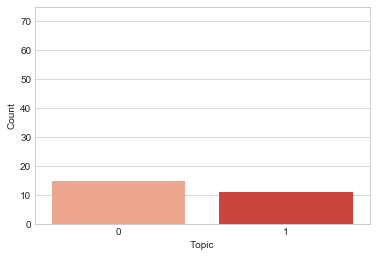

In [39]:
lda_topic_dist_test = sns.countplot(x = test_lda['Topic'], palette = 'Reds')
y_label = plt.ylabel("Count") 
y_lim = plt.ylim(0, 75)

### LDA Test Set Confusion Matrix: 'Topic' vs. 'Search Term'

In [40]:
test_lda['Recode'] = np.where(test_lda['Search Term'] == 'Ambazonia', 0, 1)

In [41]:
actuals_test_lda = test_lda['Recode']
predictions_test_lda = test_lda['Topic']
matrix_test_lda = confusion_matrix(actuals_test_lda, predictions_test_lda)
tI_errors_test_lda = (matrix_test_lda[0][1] / (matrix_test_lda[0][0] + matrix_test_lda[0][1]))
tII_errors_test_lda = (matrix_test_lda[1][0] / (matrix_test_lda[1][0] + matrix_test_lda[1][1]))
print(('LDA Test Set Type I Error Rate: {:.2%}.\n'
       'LDA Test Set Type II Error Rate: {:.2%}.\n').format(tI_errors_test_lda, tII_errors_test_lda))

LDA Test Set Type I Error Rate: 9.09%.
LDA Test Set Type II Error Rate: 33.33%.



## Model 1B: Latent Semantic Analysis. 

In [42]:
svd = TruncatedSVD(ntopics, random_state = 0)
lsa = make_pipeline(svd, preprocessing.Normalizer(copy = False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

components_lsa_train = word_topic(X_train_tfidf, X_train_lsa, terms)
topwords['LSA Training Set'] = top_words(components_lsa_train, n_top_words) 

components_lsa_test = word_topic(X_test_tfidf, X_test_lsa, terms)
topwords['LSA Test Set'] = top_words(components_lsa_test, n_top_words)

In [43]:
lsa_scaler = preprocessing.QuantileTransformer()
X_train_lsa = lsa_scaler.fit_transform(X_train_lsa)
X_test_lsa = lsa_scaler.transform(X_test_lsa)

### LSA Dataframe Creation: Training Set

In [44]:
train_lsa = pd.DataFrame()
train_lsa = X_train
lsa_df_train = pd.DataFrame(X_train_lsa, index = train_lsa.index)
train_lsa = pd.concat([train_lsa, lsa_df_train], axis = 1)
train_lsa['Topic'] = train_lsa.iloc[:, 4:6].idxmax(axis = 1)
train_lsa.head()

,Search Term,Site,Link,Document,0,1,Topic
89,Boko Haram,The Nation,http://thenationonlineng.net/boko-haram-sacks-...,suspected boko haram insurgents on saturday...,0.106486,0.893837,1
72,Ambazonia,The Nation,http://thenationonlineng.net/southern-cameroon...,agitation for independence sparks alleged...,0.560305,0.373362,0
31,Boko Haram,Vanguard,https://www.vanguardngr.com/2018/10/breaking-b...,boko haram jihadists on saturday hacked fa...,0.853656,0.772985,0
51,Ambazonia,Sun News,http://sunnewsonline.com/biafra-pro-biafra-gro...,jeff amechi agbodo onitsha the coa...,0.587546,0.400398,0
240,Boko Haram,Independent,https://www.independent.ng/fg-reintegrates-254...,bamidele shafa the federal government has sai...,0.013255,0.986755,1


### LSA Topic Distribution: Training Set

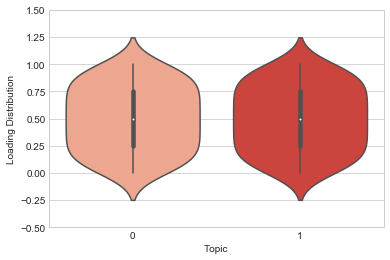

In [45]:
loadings_lsa_violin_train = sns.violinplot(data = train_lsa.iloc[:, 4:6], palette = 'Reds')
x_label = plt.xlabel("Topic") 
y_label = plt.ylabel("Loading Distribution") 
y_lim = plt.ylim(-0.5, 1.5)

### LSA Document Distribution Into Topics: Training Set

In [46]:
train_lsa['Topic'].value_counts()

0    59
1    17
Name: Topic, dtype: int64

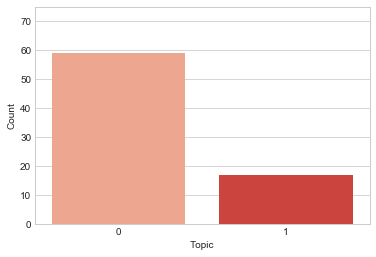

In [47]:
lsa_topic_dist_train = sns.countplot(x = train_lsa['Topic'], palette = 'Reds')
y_label = plt.ylabel("Count") 
y_lim = plt.ylim(0, 75)

### LSA Training Set Confusion Matrix: 'Topic' vs. 'Search Term'

In [48]:
train_lsa['Recode'] = np.where(train_lsa['Search Term'] == 'Ambazonia', 0, 1)

In [49]:
actuals_train_lsa = train_lsa['Recode']
predictions_train_lsa = train_lsa['Topic']
matrix_train_lsa = confusion_matrix(actuals_train_lsa, predictions_train_lsa)
tI_errors_train_lsa = (matrix_train_lsa[0][1] / (matrix_train_lsa[0][0] + matrix_train_lsa[0][1]))
tII_errors_train_lsa = (matrix_train_lsa[1][0] / (matrix_train_lsa[1][0] + matrix_train_lsa[1][1]))
print(('LSA Training Set Type I Error Rate: {:.2%}.\n'
       'LSA Training Set Type II Error Rate: {:.2%}.\n').format(tI_errors_train_lsa, tII_errors_train_lsa))

LSA Training Set Type I Error Rate: 0.00%.
LSA Training Set Type II Error Rate: 59.52%.



### LSA Dataframe Creation: Test Set

In [50]:
test_lsa = pd.DataFrame()
test_lsa = X_test
lsa_df_test = pd.DataFrame(X_test_lsa, index = test_lsa.index)
test_lsa = pd.concat([test_lsa, lsa_df_test], axis = 1)
test_lsa['Topic'] = test_lsa.iloc[:, 4:6].idxmax(axis = 1)
test_lsa.head()

,Search Term,Site,Link,Document,0,1,Topic
236,Boko Haram,Independent,https://www.independent.ng/boko-haram-kills-12...,the national emergency management agency ne...,0.053034,0.947437,1
80,Ambazonia,The Nation,http://thenationonlineng.net/grand-deception-1...,nigerians especially those living in urban c...,0.391688,0.244964,0
47,Ambazonia,Sun News,http://sunnewsonline.com/gov-ayade-raises-alar...,nan gov ben ayade of cross river h...,0.452784,0.306079,0
238,Boko Haram,Independent,https://www.independent.ng/boko-haram-sacks-tw...,suspected boko haram insurgents on saturday ...,0.136147,0.888918,1
124,Boko Haram,Tribune,https://www.tribuneonlineng.com/165727/,the igbo professionals in diasp...,1.000000,0.710085,0


### LSA Topic Distribution: Test Set

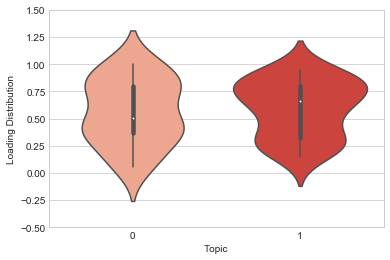

In [51]:
loadings_lsa_violin_test = sns.violinplot(data = test_lsa.iloc[:, 4:6], palette = 'Reds')
x_label = plt.xlabel("Topic") 
y_label = plt.ylabel("Loading Distribution") 
y_lim = plt.ylim(-0.5, 1.5)

### LSA Document Distribution Into Topics: Test Set

In [52]:
test_lsa['Topic'].value_counts()

0    19
1     7
Name: Topic, dtype: int64

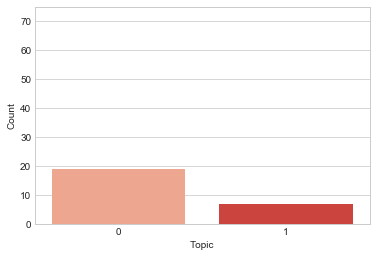

In [53]:
lsa_topic_dist_test = sns.countplot(x = test_lsa['Topic'], palette = 'Reds')
y_label = plt.ylabel("Count") 
y_lim = plt.ylim(0, 75)

### LSA Test Set Confusion Matrix: 'Topic' vs. 'Search Term'

In [54]:
test_lsa['Recode'] = np.where(test_lsa['Search Term'] == 'Ambazonia', 0, 1)

In [55]:
actuals_test_lsa = test_lsa['Recode']
predictions_test_lsa = test_lsa['Topic']
matrix_test_lsa = confusion_matrix(actuals_test_lsa, predictions_test_lsa)
tI_errors_test_lsa = (matrix_test_lsa[0][1] / (matrix_test_lsa[0][0] + matrix_test_lsa[0][1]))
tII_errors_test_lsa = (matrix_test_lsa[1][0] / (matrix_test_lsa[1][0] + matrix_test_lsa[1][1]))
print(('LSA Test Set Type I Error Rate: {:.2%}.\n'
       'LSA Test Set Type II Error Rate: {:.2%}.\n').format(tI_errors_test_lsa, tII_errors_test_lsa))

LSA Test Set Type I Error Rate: 0.00%.
LSA Test Set Type II Error Rate: 53.33%.



## Model 1C: Non-Negative Matrix Factorization

In [56]:
nmf = NMF(ntopics, random_state = 0)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
X_test_nmf = nmf.transform(X_test_tfidf)

components_nmf_train = word_topic(X_train_tfidf, X_train_nmf, terms)
topwords['NMF Training Set'] = top_words(components_nmf_train, n_top_words) 

components_nmf_test = word_topic(X_test_tfidf, X_test_nmf, terms)
topwords['NMF Test Set'] = top_words(components_nmf_test, n_top_words)

In [57]:
nmf_scaler = preprocessing.QuantileTransformer()
X_train_nmf = nmf_scaler.fit_transform(X_train_nmf)
X_test_nmf = nmf_scaler.transform(X_test_nmf)

### NMF Dataframe Creation: Training Set

In [58]:
train_nmf = pd.DataFrame()
train_nmf = X_train
nmf_df_train = pd.DataFrame(X_train_nmf, index = train_nmf.index)
train_nmf = pd.concat([train_nmf, nmf_df_train], axis = 1)
train_nmf['Topic'] = train_nmf.iloc[:, 4:6].idxmax(axis = 1)
train_nmf.head()

,Search Term,Site,Link,Document,0,1,Topic
89,Boko Haram,The Nation,http://thenationonlineng.net/boko-haram-sacks-...,suspected boko haram insurgents on saturday...,2.670874e-01,0.906821,1
72,Ambazonia,The Nation,http://thenationonlineng.net/southern-cameroon...,agitation for independence sparks alleged...,9.999999e-01,0.440353,0
31,Boko Haram,Vanguard,https://www.vanguardngr.com/2018/10/breaking-b...,boko haram jihadists on saturday hacked fa...,3.867741e-01,0.506750,1
51,Ambazonia,Sun News,http://sunnewsonline.com/biafra-pro-biafra-gro...,jeff amechi agbodo onitsha the coa...,9.347306e-02,0.560306,1
240,Boko Haram,Independent,https://www.independent.ng/fg-reintegrates-254...,bamidele shafa the federal government has sai...,1.000000e-07,0.960694,1


### NMF Loading Distributions By Tropic: Training Set

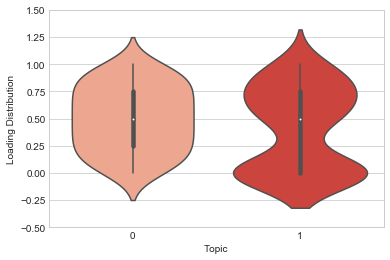

In [59]:
loadings_nmf_violin_train = sns.violinplot(data = train_nmf.iloc[:, 4:6], palette = 'Reds')
x_label = plt.xlabel("Topic") 
y_label = plt.ylabel("Loading Distribution")
y_lim = plt.ylim(-0.5, 1.5)

### NMF Document Distribution Into Topics: Training Set

In [60]:
train_nmf['Topic'].value_counts()

0    43
1    33
Name: Topic, dtype: int64

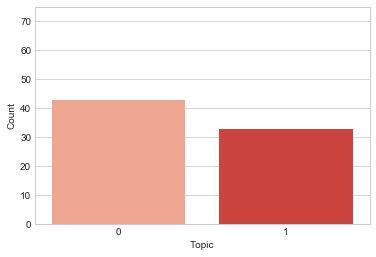

In [61]:
nmf_topic_dist_train = sns.countplot(x = train_nmf['Topic'], palette = 'Reds')
y_label = plt.ylabel("Count") 
y_lim = plt.ylim(0, 75)

### NMF Training Set Confusion Matrix: 'Topic' vs. 'Search Term'

In [62]:
train_nmf['Recode'] = np.where(train_nmf['Search Term'] == 'Ambazonia', 0, 1)

In [63]:
actuals_train_nmf = train_nmf['Recode']
predictions_train_nmf = train_nmf['Topic']
matrix_train_nmf = confusion_matrix(actuals_train_nmf, predictions_train_nmf)
tI_errors_train_nmf = (matrix_train_nmf[0][1] / (matrix_train_nmf[0][0] + matrix_train_nmf[0][1]))
tII_errors_train_nmf = (matrix_train_nmf[1][0] / (matrix_train_nmf[1][0] + matrix_train_nmf[1][1]))
print(('NMF Training Set Type I Error Rate: {:.2%}.\n'
       'NMF Training Set Type II Error Rate: {:.2%}.\n').format(tI_errors_train_nmf, tII_errors_train_nmf))

NMF Training Set Type I Error Rate: 23.53%.
NMF Training Set Type II Error Rate: 40.48%.



### NMF Dataframe Creation: Test Set

In [64]:
test_nmf = pd.DataFrame()
test_nmf = X_test
nmf_df_test = pd.DataFrame(X_test_nmf, index = test_nmf.index)
test_nmf = pd.concat([test_nmf, nmf_df_test], axis = 1)
test_nmf['Topic'] = test_nmf.iloc[:,4:6].idxmax(axis = 1)
test_nmf.head()

,Search Term,Site,Link,Document,0,1,Topic
236,Boko Haram,Independent,https://www.independent.ng/boko-haram-kills-12...,the national emergency management agency ne...,0.279819,0.937478,1
80,Ambazonia,The Nation,http://thenationonlineng.net/grand-deception-1...,nigerians especially those living in urban c...,0.913348,0.434859,0
47,Ambazonia,Sun News,http://sunnewsonline.com/gov-ayade-raises-alar...,nan gov ben ayade of cross river h...,0.331607,0.430855,1
238,Boko Haram,Independent,https://www.independent.ng/boko-haram-sacks-tw...,suspected boko haram insurgents on saturday ...,0.262744,0.902630,1
124,Boko Haram,Tribune,https://www.tribuneonlineng.com/165727/,the igbo professionals in diasp...,0.269222,0.691044,1


### NMF Loading Distributions By Topic: Test Set

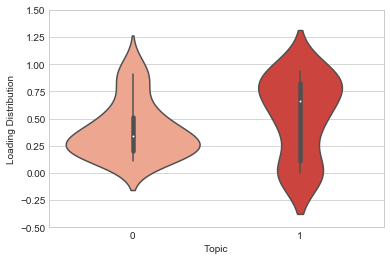

In [65]:
loadings_nmf_violin_test = sns.violinplot(data = test_nmf.iloc[:, 4:6], palette = 'Reds')
x_label = plt.xlabel("Topic") 
y_label = plt.ylabel("Loading Distribution") 
y_lim = plt.ylim(-0.5, 1.5)

### NMF Document Distribution Into Topics: Test Set

In [66]:
test_nmf['Topic'].value_counts()

1    18
0     8
Name: Topic, dtype: int64

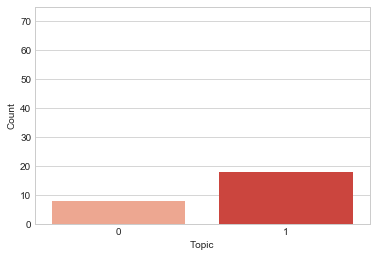

In [67]:
nmf_topic_dist_test = sns.countplot(x = test_nmf['Topic'], palette = 'Reds')
y_label = plt.ylabel("Count") 
y_lim = plt.ylim(0, 75)

### NMF Test Set Confusion Matrix: 'Topic' vs. 'Search Term'

In [68]:
test_nmf['Recode'] = np.where(test_nmf['Search Term'] == 'Ambazonia', 0, 1)

In [69]:
actuals_test_nmf = test_nmf['Recode']
predictions_test_nmf = test_nmf['Topic']
matrix_test_nmf = confusion_matrix(actuals_test_nmf, predictions_test_nmf)
tI_errors_test_nmf = (matrix_test_nmf[0][1] / (matrix_test_nmf[0][0] + matrix_test_nmf[0][1]))
tII_errors_test_nmf = (matrix_test_nmf[1][0] / (matrix_test_nmf[1][0] + matrix_test_nmf[1][1]))
print(('NMF Test Set Type I Error Rate: {:.2%}.\n'
       'NMF Test Set Type II Error Rate: {:.2%}.\n').format(tI_errors_test_nmf, tII_errors_test_nmf))

NMF Test Set Type I Error Rate: 54.55%.
NMF Test Set Type II Error Rate: 20.00%.



## Top Words Inspection

### Dataframe Creation

In [70]:
df_topwords = pd.DataFrame(topwords)
df_topwords

,LDA Training Set,LDA Test Set,LSA Training Set,LSA Test Set,NMF Training Set,NMF Test Set
0,southern 2.47,southern 0.94,southern 2.63,insurgents 2.04,southern 0.53,insurgents 0.27
0,president 1.84,revolutionary 0.7,president 2.57,troops 1.04,president 0.51,southern 0.24
0,french 1.58,republic 0.56,country 2.11,southern 1.02,country 0.47,group 0.15
0,country 1.48,independence 0.53,insurgents 2.05,group 0.9,biya 0.45,troops 0.14
0,danare 1.46,refugees 0.51,french 1.93,division 0.9,french 0.43,communities 0.13
1,insurgents 1.92,insurgents 1.88,initiative 0.66,insurgents 0.56,initiative 0.47,insurgents 0.09
1,hauwa 1.63,troops 0.91,reintegration 0.6,maiduguri 0.27,reintegration 0.43,maiduguri 0.04
1,killed 1.47,maiduguri 0.82,affected 0.59,biu 0.21,collaboration 0.41,attacks 0.04
1,terrorists 1.41,biu 0.74,collaboration 0.56,farmers 0.2,development 0.39,troops 0.03
1,worker 1.26,division 0.71,development 0.55,troops 0.2,repented 0.39,farmers 0.03


### Checking Ambiguous Top Words' Document Prevalence By Search Term: Training & Test Sets

In [71]:
X_train[X_train['Document'].str.contains('affected')]['Search Term'].value_counts()

Boko Haram    7
Ambazonia     1
Name: Search Term, dtype: int64

In [72]:
X_test[X_test['Document'].str.contains('affected')]['Search Term'].value_counts()

Boko Haram    3
Name: Search Term, dtype: int64

In [73]:
X_train[X_train['Document'].str.contains('collaboration')]['Search Term'].value_counts()

Boko Haram    4
Ambazonia     1
Name: Search Term, dtype: int64

In [74]:
X_test[X_test['Document'].str.contains('collaboration')]['Search Term'].value_counts()

Series([], Name: Search Term, dtype: int64)

In [75]:
X_train[X_train['Document'].str.contains('development')]['Search Term'].value_counts()

Boko Haram    9
Ambazonia     8
Name: Search Term, dtype: int64

In [76]:
X_test[X_test['Document'].str.contains('development')]['Search Term'].value_counts()

Boko Haram    2
Ambazonia     1
Name: Search Term, dtype: int64

In [77]:
X_train[X_train['Document'].str.contains('initiative')]['Search Term'].value_counts()

Boko Haram    9
Ambazonia     1
Name: Search Term, dtype: int64

In [78]:
X_test[X_test['Document'].str.contains('initiative')]['Search Term'].value_counts()

Series([], Name: Search Term, dtype: int64)

In [79]:
X_train[X_train['Document'].str.contains('reintegration')]['Search Term'].value_counts()

Boko Haram    4
Name: Search Term, dtype: int64

In [80]:
X_test[X_test['Document'].str.contains('reintegration')]['Search Term'].value_counts()

Series([], Name: Search Term, dtype: int64)

In [81]:
X_train[X_train['Document'].str.contains('repented')]['Search Term'].value_counts()

Boko Haram    4
Name: Search Term, dtype: int64

In [82]:
X_test[X_test['Document'].str.contains('repented')]['Search Term'].value_counts()

Series([], Name: Search Term, dtype: int64)

### Top Word List

In [83]:
for column in df_topwords.columns: 
    df_topwords[column] = df_topwords[column].str.replace('\s\d.*', '')

words_allmethods = []
for column in df_topwords.columns: 
    words_allmethods.append(df_topwords[column].tolist())
    
words_allmethods_flat = sorted(set([string for sublist in words_allmethods for string in sublist]))
print(words_allmethods_flat)

['affected', 'attacks', 'biu', 'biya', 'collaboration', 'communities', 'country', 'danare', 'development', 'division', 'farmers', 'french', 'group', 'hauwa', 'independence', 'initiative', 'insurgents', 'killed', 'maiduguri', 'president', 'refugees', 'reintegration', 'repented', 'republic', 'revolutionary', 'southern', 'terrorists', 'troops', 'worker']


### Top Word Loadings By Model: Training Set

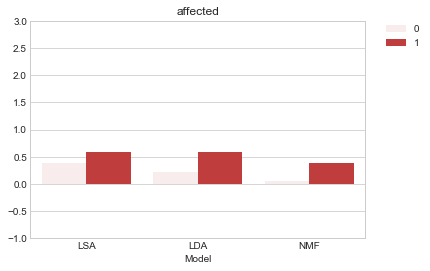

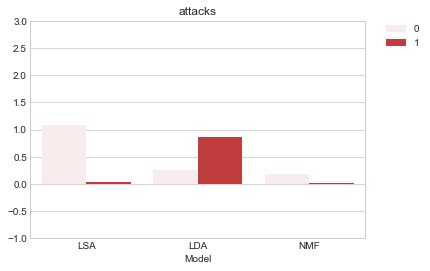

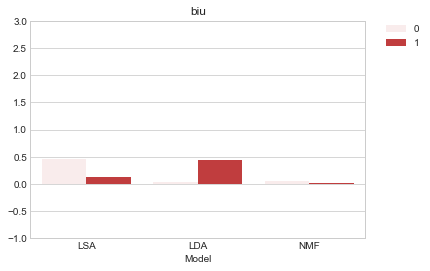

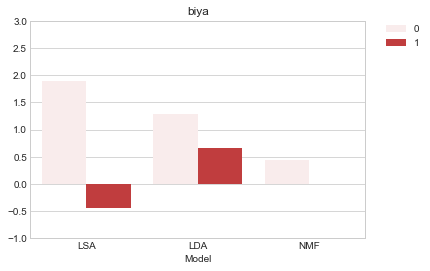

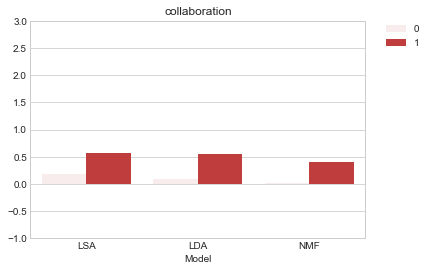

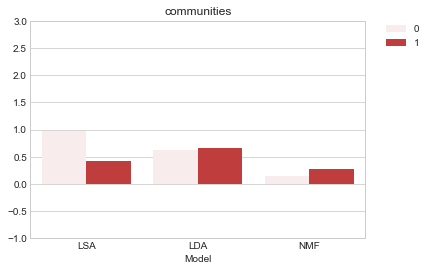

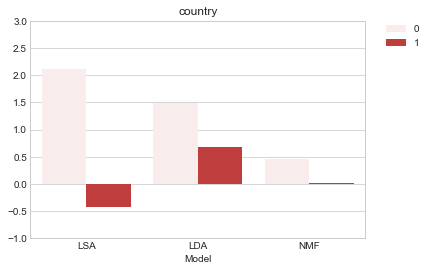

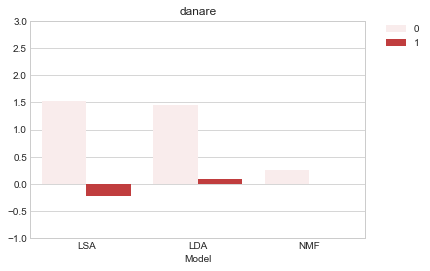

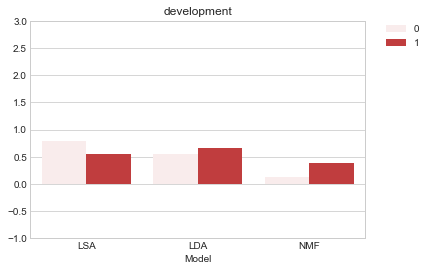

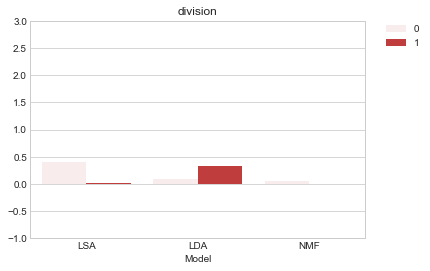

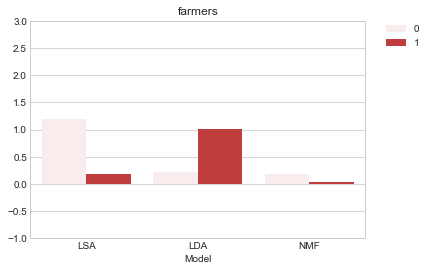

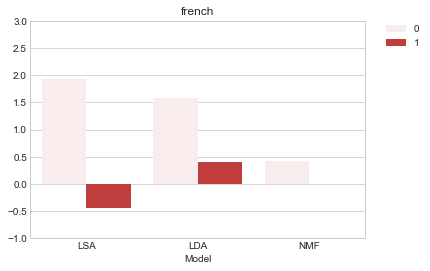

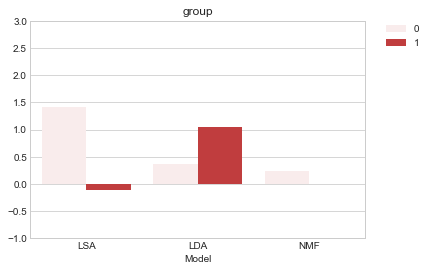

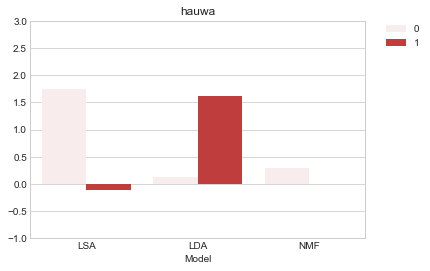

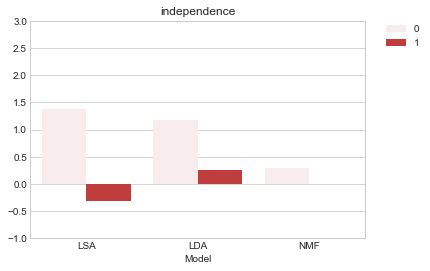

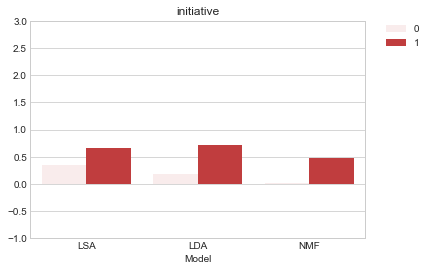

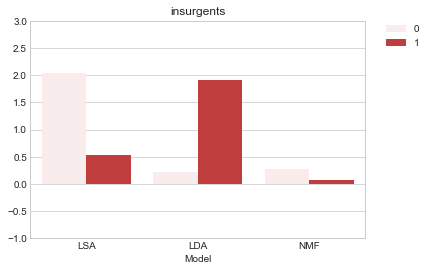

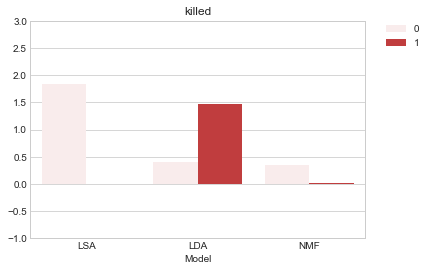

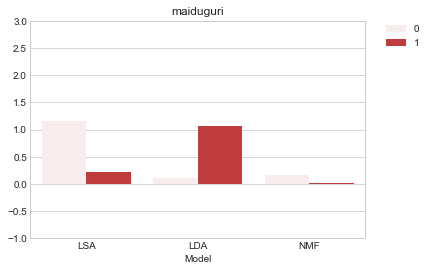

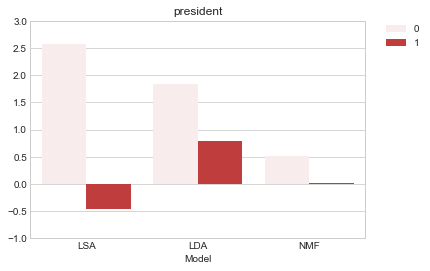

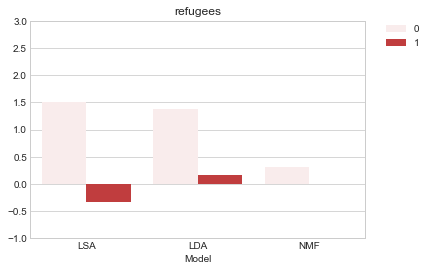

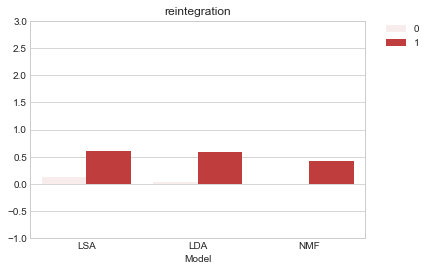

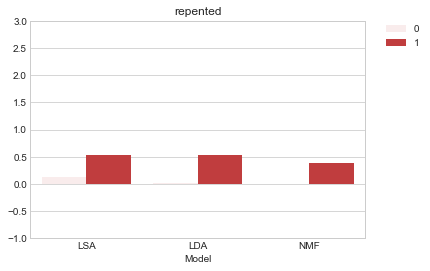

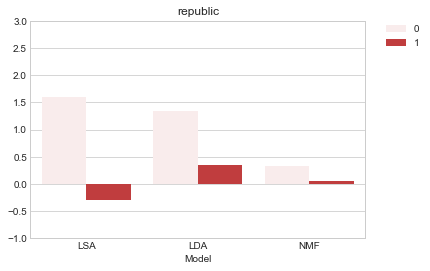

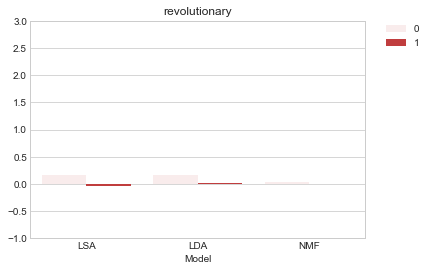

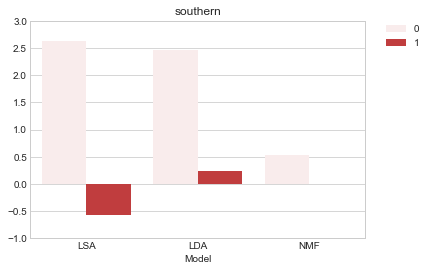

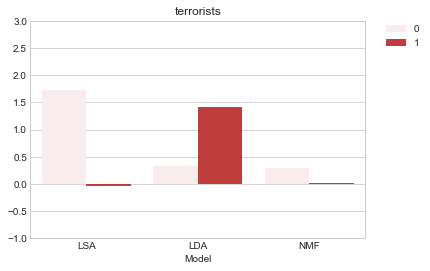

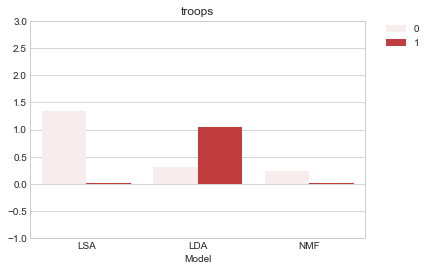

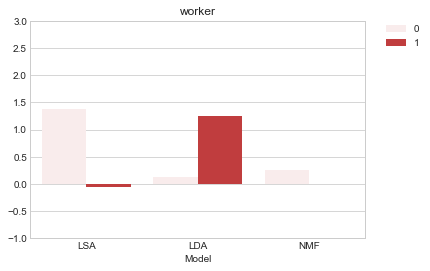

In [84]:
targetwords = sorted(list(set(words_allmethods_flat)))
wordloadings = pd.DataFrame(columns = targetwords)
                  
for word in targetwords:
    loadings = components_lsa_train.loc[word].append(components_lda_train.loc[word]).append(components_nmf_train.loc[word])
    wordloadings[word] = loadings

wordloadings['Model'] = np.repeat(['LSA', 'LDA', 'NMF'], 2, axis = 0)
wordloadings['Loading'] = [0, 1] * 3

for word in targetwords:
    sns.barplot(x = 'Model', y = word, hue = 'Loading', color='tab:red', data = wordloadings)
    plt.title(word)
    plt.ylabel('')
    plt.ylim(-1, 3)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
    plt.show()

### Top Word Loadings By Model: Test Set

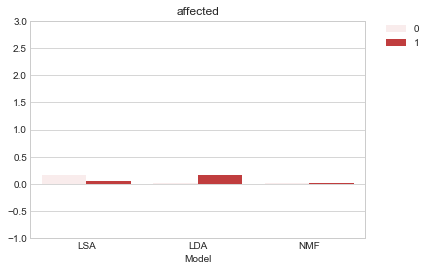

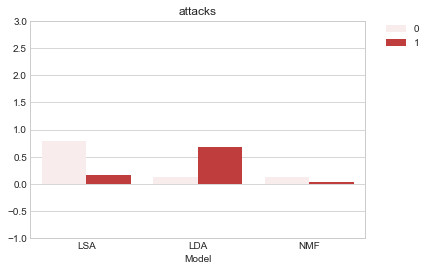

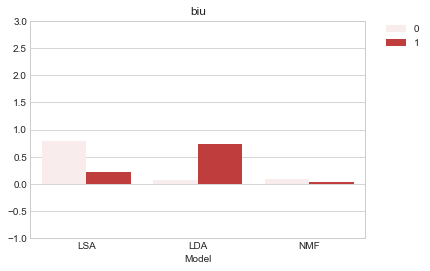

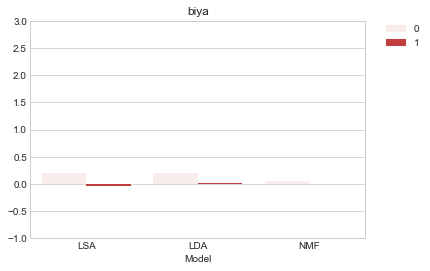

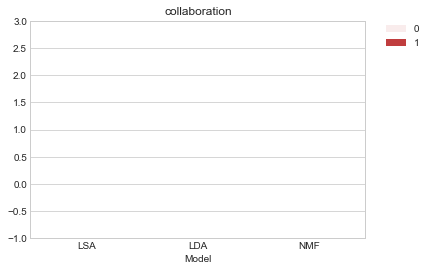

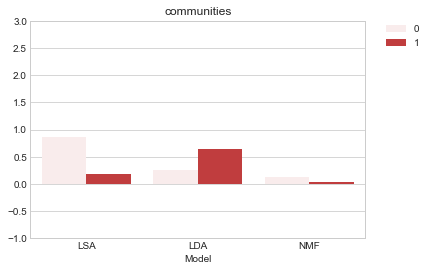

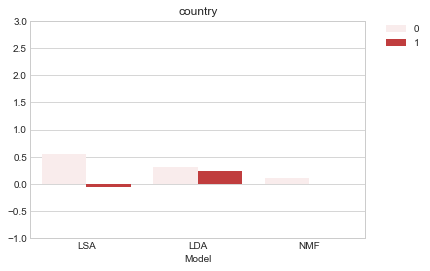

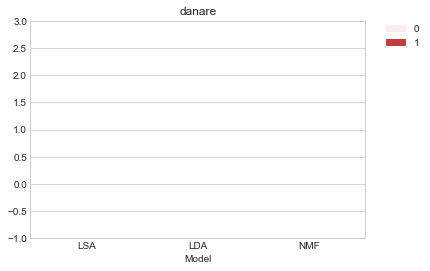

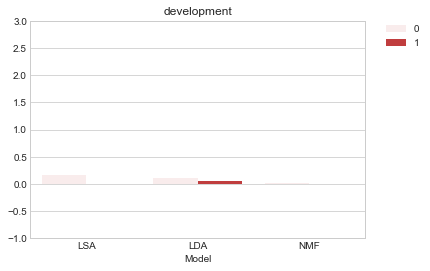

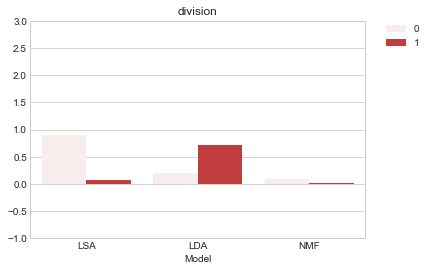

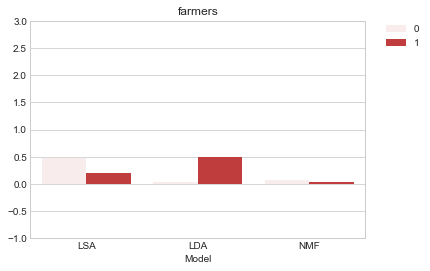

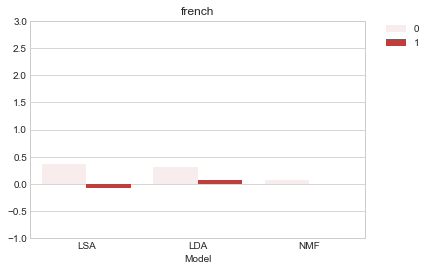

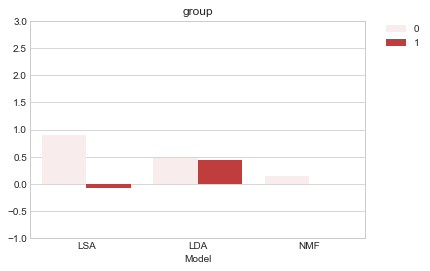

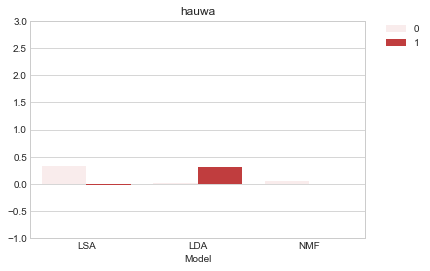

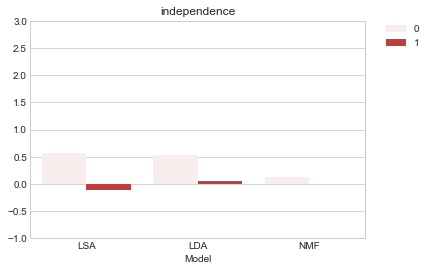

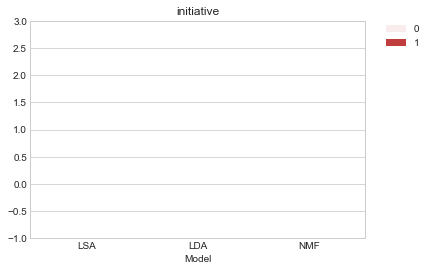

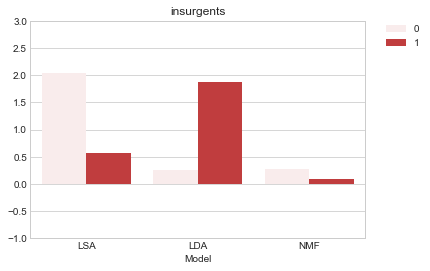

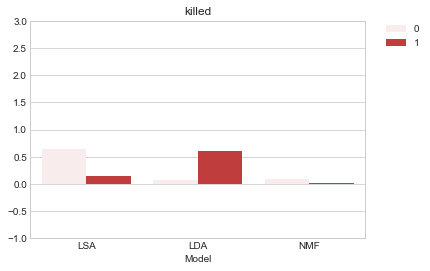

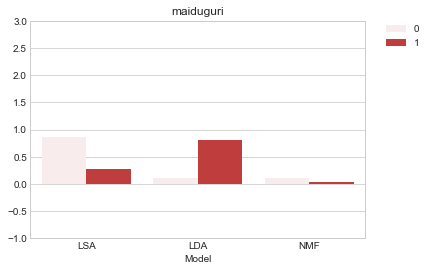

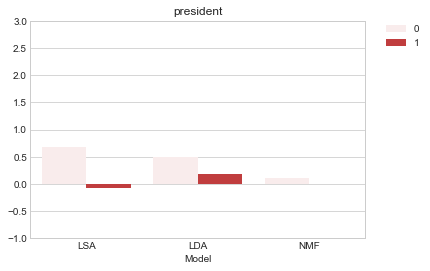

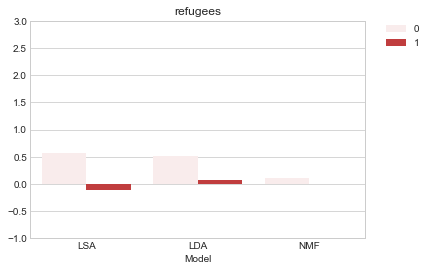

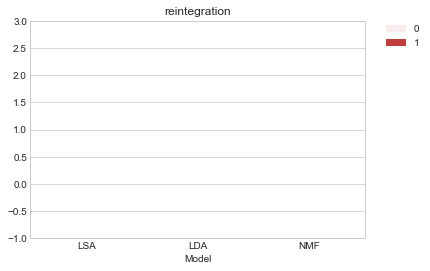

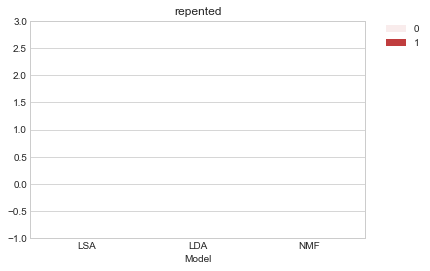

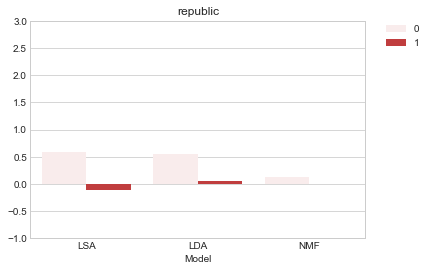

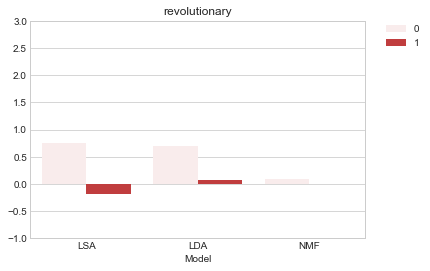

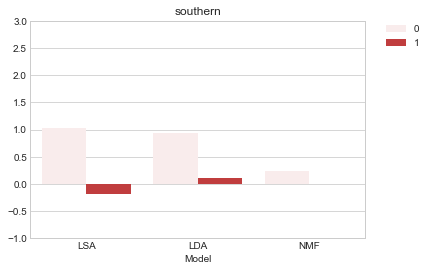

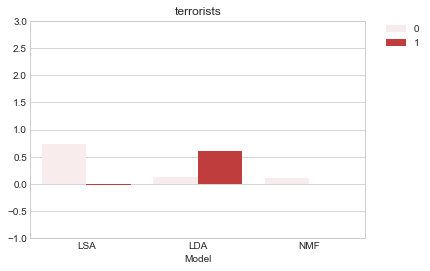

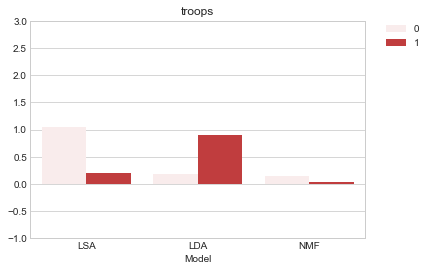

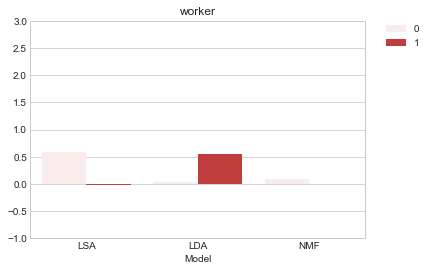

In [85]:
targetwords = sorted(list(set(words_allmethods_flat)))
wordloadings = pd.DataFrame(columns = targetwords)
                  
for word in targetwords:
    loadings = components_lsa_test.loc[word].append(components_lda_test.loc[word]).append(components_nmf_test.loc[word])
    wordloadings[word] = loadings

wordloadings['Model'] = np.repeat(['LSA','LDA','NMF'], 2, axis = 0)
wordloadings['Loading'] = [0, 1] * 3

for word in targetwords:
    sns.barplot(x = 'Model', y = word, hue = 'Loading', color = 'tab:red', data = wordloadings)
    plt.title(word)
    plt.ylabel('')
    plt.ylim(-1, 3)
    legend = plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
    plt.show()